# Multitaper and Hamonic Ftest


,Time:512Hz,Epoch,FP1,FP2,F7,Fz,F8,T3,C3,Cz,C4,T4,T5,Pz,T6,O1,O2,Event Id,Event Date,Event Duration
250880,0.000000,7840,29068.474609,16043.802734,66537.117188,48942.300781,46747.140625,37714.492188,41452.582031,46752.359375,39487.441406,36383.238281,29403.966797,64742.707031,48880.750000,48013.484375,50548.804688,NaN,NaN,NaN
250881,0.001953,7840,28882.087891,15877.711914,66265.804688,48685.671875,46661.941406,37437.453125,41160.683594,46473.718750,39199.546875,36090.765625,29135.296875,64464.402344,48601.859375,47746.492188,50276.796875,NaN,NaN,NaN
250882,0.003906,7840,28480.357422,15619.443359,65925.687500,48465.843750,46358.433594,37192.238281,40900.492188,46222.437500,38959.296875,35792.894531,28879.283203,64208.078125,48338.355469,47476.367188,50000.710938,NaN,NaN,NaN
250883,0.005859,7840,28442.494141,15361.359375,65869.085938,48370.648438,46011.203125,37144.343750,40838.093750,46162.632812,38914.601562,35716.761719,28817.134766,64145.109375,48262.589844,47398.531250,49921.441406,NaN,NaN,NaN
250884,0.007812,7840,28484.421875,15680.270508,66102.539062,48491.339844,46259.292969,37318.671875,41024.398438,46339.375000,39082.535156,35938.675781,28998.343750,64328.062500,48468.093750,47584.843750,50107.140625,NaN,NaN,NaN


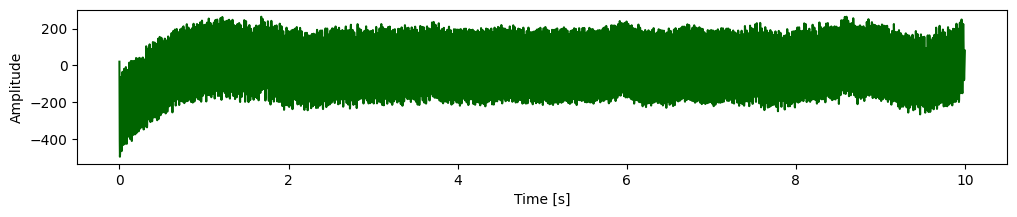

H_k(0):[0.09804702 0.         0.06682723 0.         0.05486128 0.
 0.04390193]


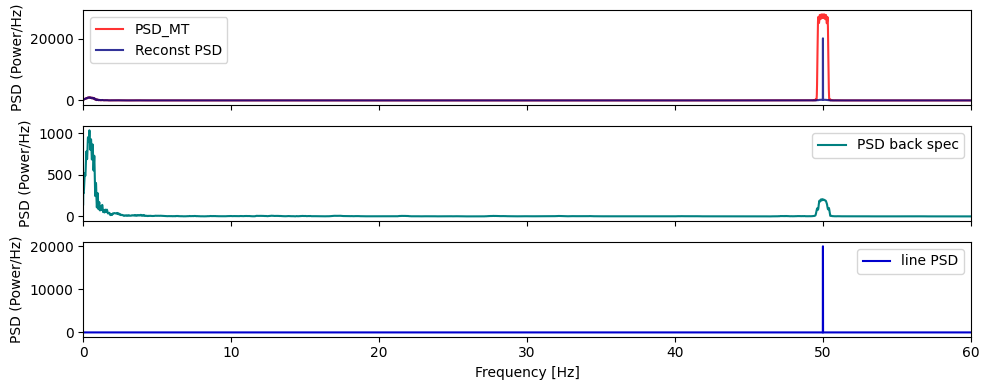

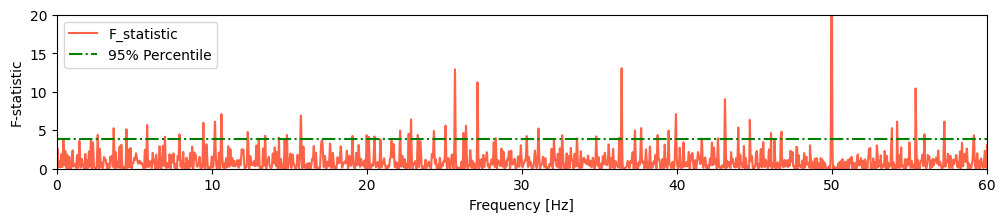

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
from python.multitaper import MultiTaper_Periodogram
import matplotlib.pyplot as plt


df = pd.read_csv("../../test_data/record.csv")
df = df[(df["Time:512Hz"] >= 490) & (df["Time:512Hz"] <= 500)]
df["Time:512Hz"] = df["Time:512Hz"] - df["Time:512Hz"].iloc[0]
display(df.head())
fs_EEG =512
signal_EEG = df["C3"].to_numpy()
time_EEG = df["Time:512Hz"].to_numpy()


def lowpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  # フィルタのオーダーと正規化周波数を計算
    b, a = signal.butter(N, Wn, btype="low")     # ハイパスフィルターを設計
    y = signal.filtfilt(b, a, x)                  # フィルタ適用（ゼロ位相遅延）
    return y                                      # フィルタ後の信号を返す
def highpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  # フィルタのオーダーと正規化周波数を計算
    b, a = signal.butter(N, Wn, btype="high")     # ハイパスフィルターを設計
    y = signal.filtfilt(b, a, x)                  # フィルタ適用（ゼロ位相遅延）
    return y                                      # フィルタ後の信号を返す
def bandpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "band")           #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y    

# ハイパスフィルターの設定
cutoff = 0.4  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 30    # 阻止域最小減衰[dB]
signal_EEG = highpass(signal_EEG, fs_EEG, cutoff, gpass, gstop)


cutoff = 60  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
signal_EEG = lowpass(signal_EEG, fs_EEG, cutoff, gpass, gstop)

notch_freq = 50
Q = 40
b, a = signal.iirnotch(notch_freq, Q, fs_EEG)
# signal_EEG = signal.filtfilt(b, a, signal_EEG)

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(time_EEG, signal_EEG, color='darkgreen')
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time [s]")
plt.show()

MTSpec = MultiTaper_Periodogram(NW=4,nfft=2**16, K=7)
MTSpec.MT_Spec(signal_EEG, fs_EEG)
MTSpec.Harmonic_Ftest(p_level=0.05)

fig, axes = plt.subplots(3, 1, figsize=(10, 4),sharex=True, sharey=False)  # 3行1列のサブプロット

# ---- 1つ目のプロット (PSD) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='PSD_MT', alpha=0.8, c='r', lw=1.5)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.8, c='navy', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_yscale("log")
ax.set_xlim(0,60)
ax.legend()

# ---- プロット (Reconstructed PSD) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='PSD back spec', alpha=1, c='teal', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.legend()
# ---- プロット (Reconstructed PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='mediumblue', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlabel('Frequency [Hz]')
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()


# ---- プロット (F-statistic) ----
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=1.5)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim(0,60)
ax.set_ylim(0,20)
ax.legend()


,Time,PPG,ECG,resp
0,0.000,1.360704,0.455078,1.750153
1,0.008,1.394917,0.404785,1.750153
2,0.016,1.444770,0.339844,1.750153
3,0.024,1.508309,0.300293,1.750153
4,0.032,1.581623,0.285156,1.624924


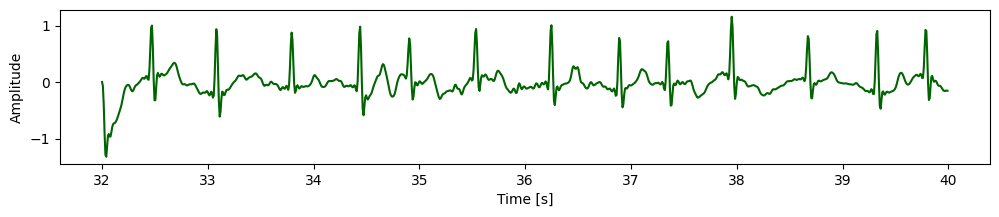

H_k(0):[0.17753899 0.         0.1210059  0.         0.0993166  0.
 0.07929003]


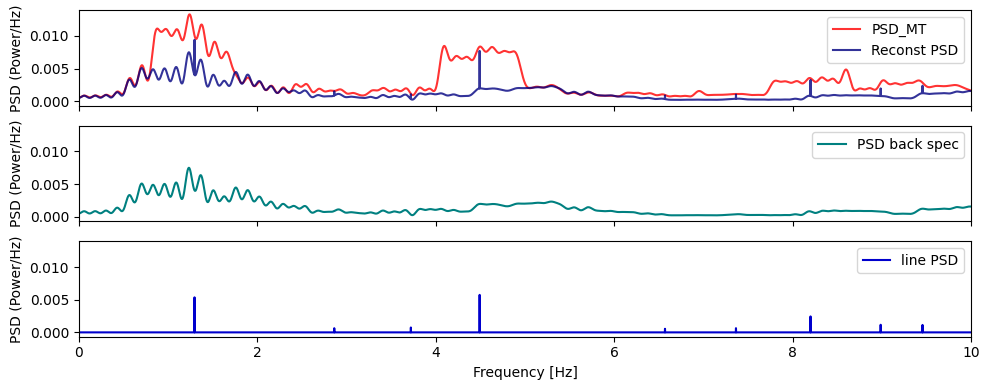

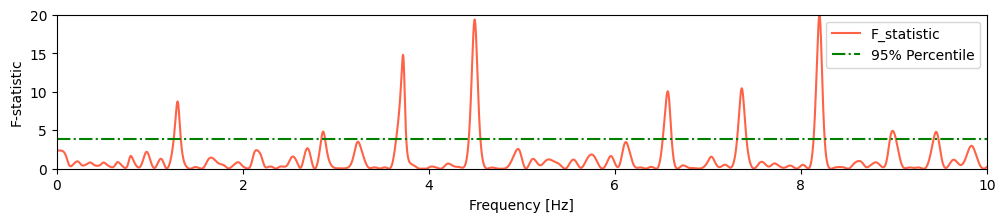

In [52]:
df_ecg = pd.read_csv("../../test_data/ECG_data.csv")

display(df_ecg.head())
fs_ECG = 125
signal_ecg = df_ecg["ECG"].iloc[4000:5000].to_numpy()
time_ecg = df_ecg["Time"].iloc[4000:5000].to_numpy()



def highpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  # フィルタのオーダーと正規化周波数を計算
    b, a = signal.butter(N, Wn, btype="high")     # ハイパスフィルターを設計
    y = signal.filtfilt(b, a, x)                  # フィルタ適用（ゼロ位相遅延）
    return y                                      # フィルタ後の信号を返す

# ハイパスフィルターの設定
cutoff = 1.0  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
signal_ecg = highpass(signal_ecg, fs_ECG, cutoff, gpass, gstop)

cutoff = 25  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
signal_ecg = lowpass(signal_ecg, fs_ECG, cutoff, gpass, gstop)

fig = plt.figure(1, figsize=(12,2))
ax = fig.add_subplot()
ax.plot(time_ecg, signal_ecg, color='darkgreen')
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time [s]")
plt.show()




MTSpec = MultiTaper_Periodogram(NW=4, nfft=2**16)
MTSpec.MT_Spec(signal_ecg, fs_ECG)
MTSpec.Harmonic_Ftest(p_level=0.05)

fig, axes = plt.subplots(3, 1, figsize=(10, 4),sharex=True, sharey=True)  # 3行1列のサブプロット
# ---- 1つ目のプロット (PSD) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='PSD_MT', alpha=0.8, c='r', lw=1.5)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.8, c='navy', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_yscale("log")
ax.set_xlim(0,10)
ax.legend()

# ---- プロット (Reconstructed PSD) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='PSD back spec', alpha=1, c='teal', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.legend()
# ---- プロット (Reconstructed PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='mediumblue', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlabel('Frequency [Hz]')
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()


# ---- プロット (F-statistic) ----
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=1.5)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim(0,10)
ax.set_ylim(0,20)
ax.legend()


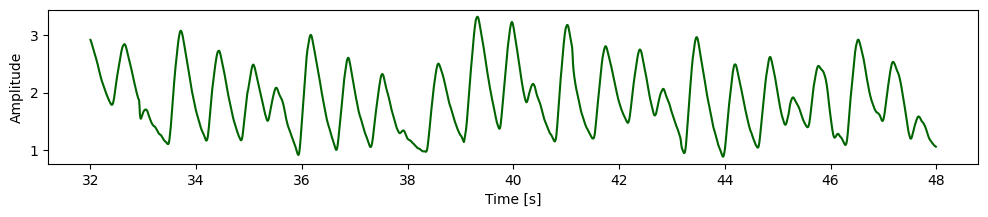

H_k(0):[0.26891909 0.         0.18005463 0.         0.13677299]


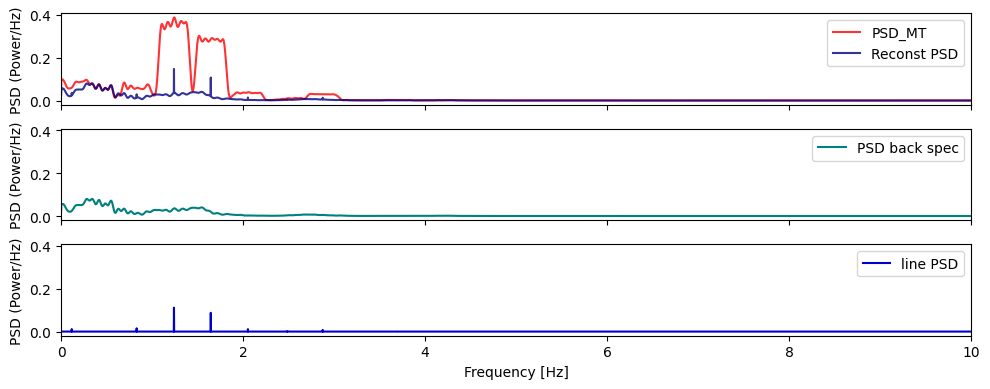

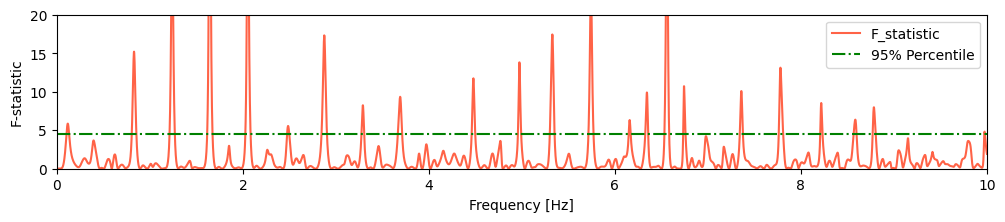

In [53]:
signal_ppg = df_ecg["PPG"].iloc[4000:6000].to_numpy()
time_ppg = df_ecg["Time"].iloc[4000:6000].to_numpy()

# signal_ppg = highpass(signal_ppg, fs_ECG, cutoff, gpass, gstop)
# signal_ppg = lowpass(signal_ppg, fs_ECG, cutoff, gpass, gstop)

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(time_ppg, signal_ppg, color='darkgreen')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
plt.show()

MTSpec = MultiTaper_Periodogram(NW=3,nfft=2**16)
MTSpec.MT_Spec(signal_ppg, fs_ECG)
MTSpec.Harmonic_Ftest(p_level=0.05)


fig, axes = plt.subplots(3, 1, figsize=(10, 4),sharex=True, sharey=True)  # 3行1列のサブプロット
# ---- 1つ目のプロット (PSD) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='PSD_MT', alpha=0.8, c='r', lw=1.5)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.8, c='navy', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_yscale("log")
ax.set_xlim(0,10)
ax.legend()

# ---- プロット (Reconstructed PSD) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='PSD back spec', alpha=1, c='teal', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.legend()
# ---- プロット (Reconstructed PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='mediumblue', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlabel('Frequency [Hz]')
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()


# ---- プロット (F-statistic) ----
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=1.5)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim(0,10)
ax.set_ylim(0,20)
ax.legend()

## 減衰信号

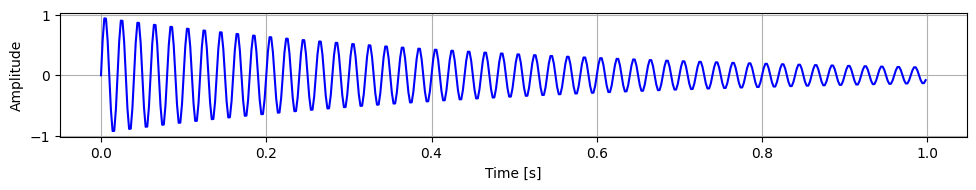

H_k(0):[0.03140092 0.         0.02140142 0.         0.01756012 0.
 0.0139775 ]


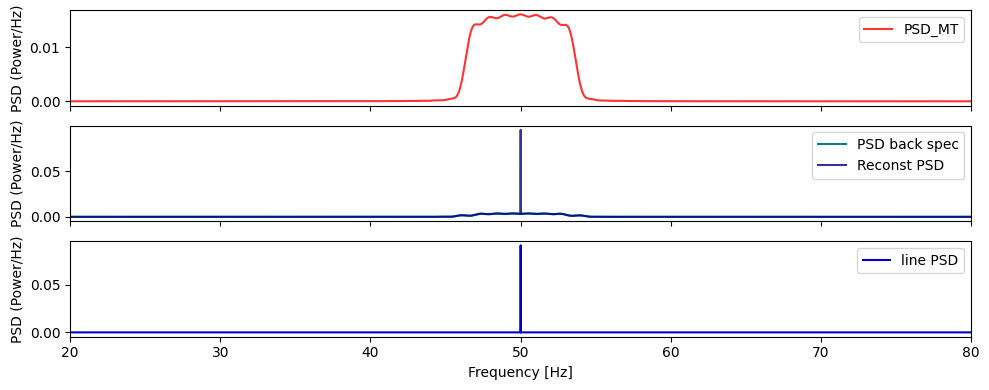

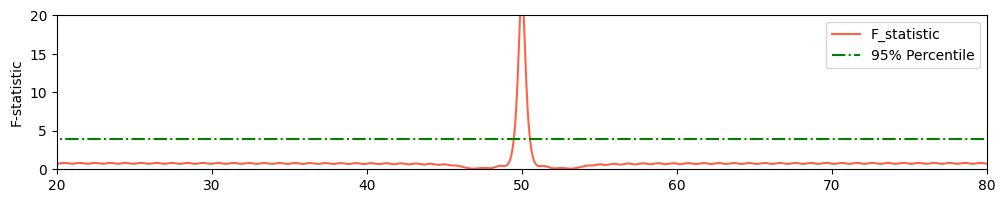

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import math


# パラメータ設定
fs_e = 500  # サンプリング周波数 (Hz)
t = np.linspace(0, 1, fs_e, endpoint=False)  # 時間軸（1秒間分のデータ）

f = 50  # 振動の周波数 (Hz)
decay_rate = 2  # 減衰率（大きいほど早く減衰）

# 減衰振動の生成
amplitude = np.exp(-decay_rate * t)  # 減衰を表す指数関数
oscillation = np.sin(2 * np.pi * f * t)  # 正弦波
# oscillation = np.clip(oscillation, -0.6, 0.6)
am_signal = amplitude * oscillation  # 減衰振動

# noisy_am_signal = am_signal
# プロット
fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot()
ax.plot(t, am_signal, label="AM Signal", color='b')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.tight_layout()
plt.show()


MTSpec = MultiTaper_Periodogram(NW=4,nfft=2**16)
MTSpec.MT_Spec(am_signal, fs_e)
MTSpec.Harmonic_Ftest(p_level=0.05)

fig, axes = plt.subplots(3, 1, figsize=(10, 4),sharex=True, sharey=False)  # 3行1列のサブプロット
# ---- 1つ目のプロット (PSD) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='PSD_MT', alpha=0.8, c='r', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_yscale("log")
ax.set_xlim(20,80)
ax.legend()

# ---- プロット (Reconstructed PSD) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='PSD back spec', alpha=1, c='teal', lw=1.5)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.8, c='navy', lw=1.5)

ax.set_ylabel('PSD (Power/Hz)')
ax.legend()
# ---- プロット (Reconstructed PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='mediumblue', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlabel('Frequency [Hz]')
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()


# ---- プロット (F-statistic) ----
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=1.5)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlim(20,80)
ax.set_ylim(0,20)
ax.legend()



0th 0.9999999997060941
1th 0.9999999723687615
2th 0.9999987916126629
3th 0.9999675893000647
4th 0.9994105128955671
5th 0.9925078649626218
6th 0.9366654986606355


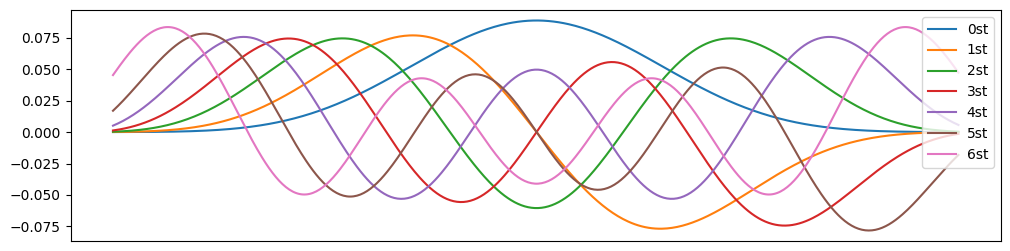

nw:4, N:500, W:4.0


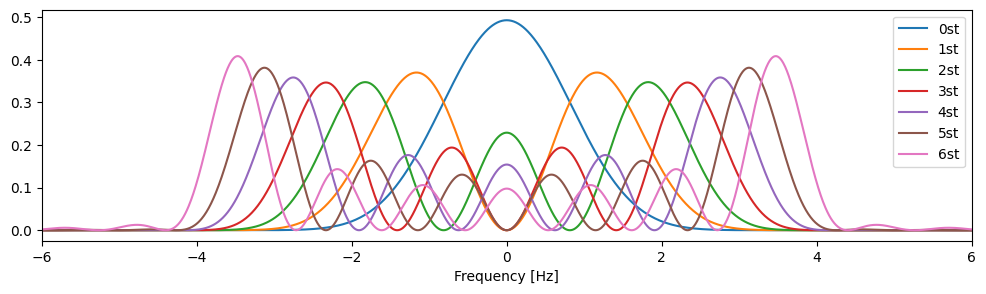

In [43]:
plt.figure(figsize=(12, 3))

for k_i in range(MTSpec.K):
    # k_i 番目のターパー
    plt.plot(MTSpec.k_DPSS[k_i, :], label=f'{k_i}st') 
    print(f"{k_i}th {MTSpec.eigenvalues[k_i]}")

plt.xticks([])
# plt.grid()
plt.legend(loc='upper right')
plt.show()


# FFT の計算
H_k = np.fft.fft(MTSpec.k_DPSS, n=MTSpec.nfft, axis=1)
H_k_PSD = (1 / MTSpec.fs) * np.abs(H_k)**2  

# 周波数軸を対応させる
freqs = np.fft.fftfreq(MTSpec.nfft, d=1/MTSpec.fs)  

# fftshift を適用
H_k_PSD_shifted = np.fft.fftshift(H_k_PSD, axes=1)  # 周波数成分をシフト
freqs_shifted = np.fft.fftshift(freqs)  # 周波数軸もシフト

print(f"nw:{MTSpec.NW}, N:{MTSpec.N}, W:{MTSpec.NW / MTSpec.N * MTSpec.fs}")

# プロット
plt.figure(figsize=(12, 3))
for k_i in range(MTSpec.K):
    plt.plot(freqs_shifted, H_k_PSD_shifted[k_i, :], label=f'{k_i}st') 

# 軸の範囲を適切に設定
plt.xlim(-MTSpec.NW / MTSpec.N * MTSpec.fs * 1.5, MTSpec.NW / MTSpec.N * MTSpec.fs * 1.5)
# plt.yscale("log")
plt.xlabel("Frequency [Hz]")
plt.legend(loc='upper right')
plt.show()

## SSVEP 4Hz

['EEG', 'suppl_info']


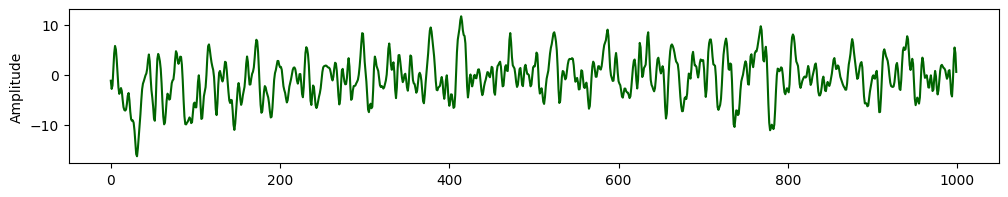

H_k(0):[0.08668896 0.         0.05908491 0.         0.04849444 0.
 0.03871583]


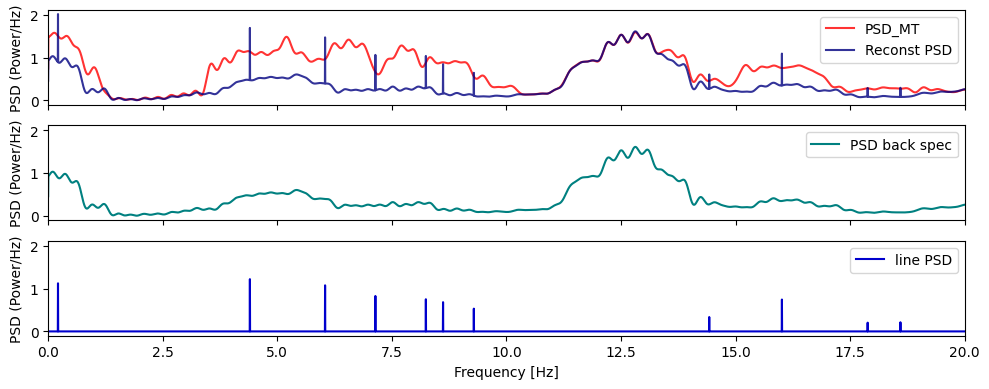

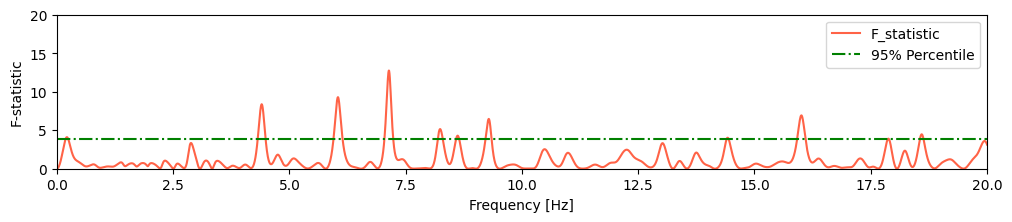

In [54]:
import scipy.io as sio
import pandas as pd

mat_data = sio.loadmat(
    '../../test_data/S16.mat',
    struct_as_record=False,
    squeeze_me=True
)

# (1,1) shape の struct: 例: data -> mat_struct
data_struct = mat_data["data"]  # これが mat_struct

# フィールド一覧を確認
print(data_struct._fieldnames)  # 例: ['EEG', 'suppl_info']

# フィールドへアクセス
EEG = getattr(data_struct, "EEG")         # data_struct.EEG と同等
info = getattr(data_struct, "suppl_info") # data_struct.suppl_info と同等

# Pz:48 O1 61
ssvep = EEG[48,:,0,1]
fs_vep = 256

# ハイパスフィルターの設定
cutoff = 0.2  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 20    # 阻止域最小減衰[dB]
ssvep = highpass(ssvep, fs_vep, cutoff, gpass, gstop)


cutoff = 60  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
ssvep = lowpass(ssvep, fs_vep, cutoff, gpass, gstop)


fig = plt.figure(1, figsize=(12,2))
ax = fig.add_subplot()
ax.plot(ssvep, color='darkgreen')
ax.set_ylabel("Amplitude")
plt.show()

MTSpec = MultiTaper_Periodogram(NW=4,nfft=2**16)
MTSpec.MT_Spec(ssvep, fs_vep)
MTSpec.Harmonic_Ftest(p_level=0.05)

fig, axes = plt.subplots(3, 1, figsize=(10, 4),sharex=True, sharey=True)  # 3行1列のサブプロット
# ---- 1つ目のプロット (PSD) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='PSD_MT', alpha=0.8, c='r', lw=1.5)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.8, c='navy', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_yscale("log")
ax.set_xlim(0,20)
ax.legend()

# ---- プロット (Reconstructed PSD) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='PSD back spec', alpha=1, c='teal', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.legend()
# ---- プロット (Reconstructed PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='mediumblue', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlabel('Frequency [Hz]')
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()


# ---- プロット (F-statistic) ----
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=1.5)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim(0,20)
ax.set_ylim(0,20)
ax.legend()